## Logistic Regression

Despite the name, [Logistic Regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) is a popular and powerful method for classification.  Unlike other classification methods, it is able to accurately compute the probability that a sample belongs to one of several mutually-exclusive classes.  In this tutorial, we'll go through the process of evaluating models using accuracy and confusion matrices and selecting features to optimize a model.

For this tutorial, we will be using the [animal scat](https://topepo.github.io/caret/data-sets.html#animal-scat-data) data set.  A biologist collected animal droppings from various sites and characterized the properties (e.g. location, age, number of deposits, length) of the droppings.  The outcome variable is the species (coyote, bobcat, or grey fox) -- we want to predict which animal created the droppings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Import and Clean Data

In [2]:
df = pd.read_csv("scat.csv")

In [3]:
df.head()

,Species,Month,Year,Site,Location,Age,Number,Length,Diameter,Taper,TI,Mass,d13C,d15N,CN,ropey,segmented,flat,scrape
0,coyote,January,2012,YOLA,edge,5,2,9.5,25.7,41.9,1.63,15.89,-26.85,6.94,8.5,0,0,0,0
1,coyote,January,2012,YOLA,edge,3,2,14.0,25.4,37.1,1.46,17.61,-29.62,9.87,11.3,0,0,0,0
2,bobcat,January,2012,YOLA,middle,3,2,9.0,18.8,16.5,0.88,8.40,-28.73,8.52,8.1,1,1,0,1
3,coyote,January,2012,YOLA,middle,5,2,8.5,18.1,24.7,1.36,7.40,-20.07,5.79,11.5,1,0,0,0
4,coyote,January,2012,YOLA,edge,5,4,8.0,20.7,20.1,0.97,25.45,-23.24,7.01,10.6,0,1,0,0


In [4]:
df.dtypes

Species       object
Month         object
Year           int64
Site          object
Location      object
Age            int64
Number         int64
Length       float64
Diameter     float64
Taper        float64
TI           float64
Mass         float64
d13C         float64
d15N         float64
CN           float64
ropey          int64
segmented      int64
flat           int64
scrape         int64
dtype: object

Species, Month, Site, and Location should all be categorical variables.  The rest of the variables are fine as is.

In [5]:
for col_name in ["Species", "Month", "Site", "Location", "ropey", "segmented", "flat", "scrape"]:
    df[col_name] = df[col_name].astype("category")

In [6]:
df.dtypes

Species      category
Month        category
Year            int64
Site         category
Location     category
Age             int64
Number          int64
Length        float64
Diameter      float64
Taper         float64
TI            float64
Mass          float64
d13C          float64
d15N          float64
CN            float64
ropey        category
segmented    category
flat         category
scrape       category
dtype: object

## Data Exploration

First, let's look at the distribution of the outcome variable Species.

bobcat      57
coyote      28
gray_fox    25
Name: Species, dtype: int64


Text(0,0.5,'Number of Samples')

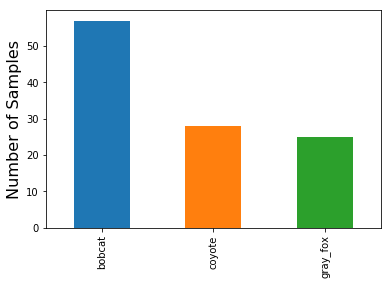

In [7]:
species_counts = df["Species"].value_counts()
print(species_counts)
species_counts.plot.bar()
plt.ylabel("Number of Samples", fontsize=16)

Our data set is imbalanced.  Meaning, we have twice as many bobcat samples as coyote or gray fox samples.

Next, we start looking at relationships of each of the input variables against the outcome variable (Species).  We start with the numerical variables.  We use box plots since the outcome variable is categorical.

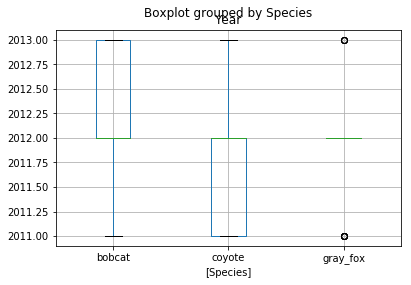

In [8]:
df[["Species", "Year"]].boxplot(by="Species")

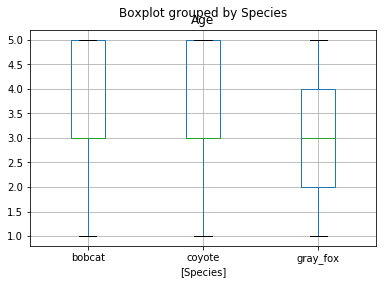

In [9]:
df[["Species", "Age"]].boxplot(by="Species")

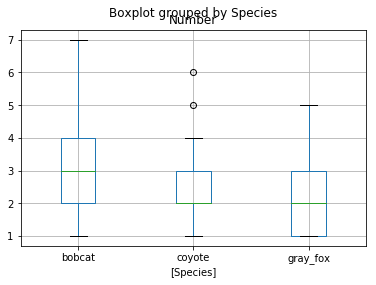

In [10]:
df[["Species", "Number"]].boxplot(by="Species")

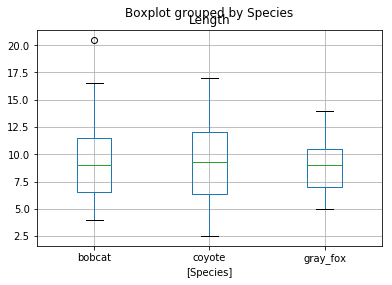

In [11]:
df[["Species", "Length"]].boxplot(by="Species")

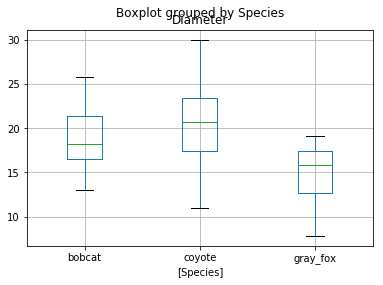

In [12]:
df[["Species", "Diameter"]].boxplot(by="Species")

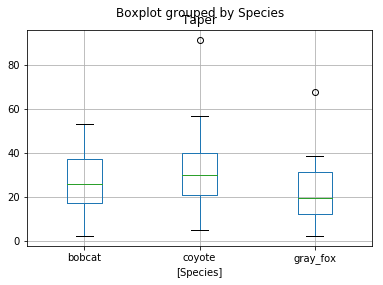

In [13]:
df[["Species", "Taper"]].boxplot(by="Species")

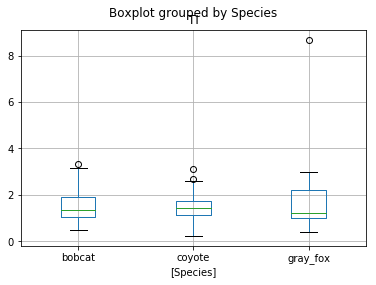

In [14]:
df[["Species", "TI"]].boxplot(by="Species")

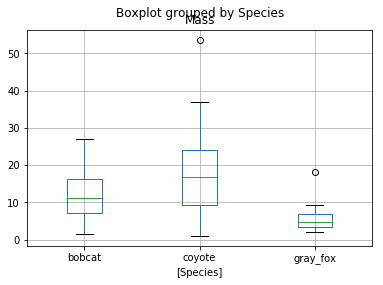

In [15]:
df[["Species", "Mass"]].boxplot(by="Species")

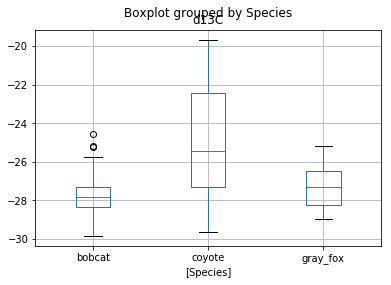

In [16]:
df[["Species", "d13C"]].boxplot(by="Species")

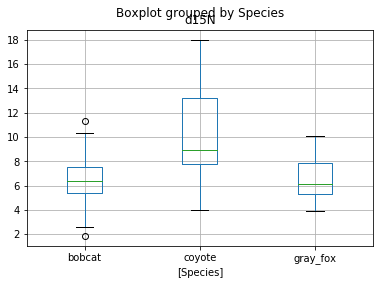

In [17]:
df[["Species", "d15N"]].boxplot(by="Species")

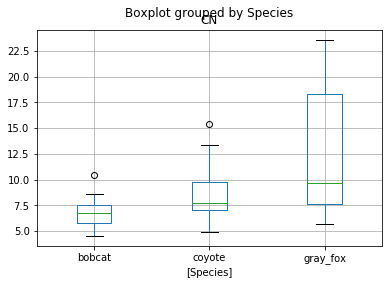

In [18]:
df[["Species", "CN"]].boxplot(by="Species")

## Feature Extraction

Next, we create dummy variables for each categorical variable.

In [19]:
df["Number_cats"] = df["Number"].astype("category")

In [20]:
categorical_columns = ["Species", "Month", "Site", "Location", "ropey", "segmented", "flat", "scrape", "Number_cats"]
dummy_columns = {}
for col_name in categorical_columns:
    dummies = pd.get_dummies(df[col_name], prefix=col_name)
    dummy_columns[col_name] = dummies.columns.values
    df = df.merge(dummies, left_index=True, right_index=True)

In [21]:
df.head()

,Species,Month,Year,Site,Location,Age,Number,Length,Diameter,Taper,...,flat_1,scrape_0,scrape_1,Number_cats_1,Number_cats_2,Number_cats_3,Number_cats_4,Number_cats_5,Number_cats_6,Number_cats_7
0,coyote,January,2012,YOLA,edge,5,2,9.5,25.7,41.9,...,0,1,0,0,1,0,0,0,0,0
1,coyote,January,2012,YOLA,edge,3,2,14.0,25.4,37.1,...,0,1,0,0,1,0,0,0,0,0
2,bobcat,January,2012,YOLA,middle,3,2,9.0,18.8,16.5,...,0,0,1,0,1,0,0,0,0,0
3,coyote,January,2012,YOLA,middle,5,2,8.5,18.1,24.7,...,0,1,0,0,1,0,0,0,0,0
4,coyote,January,2012,YOLA,edge,5,4,8.0,20.7,20.1,...,0,1,0,0,0,0,1,0,0,0


## Experimental Setup

In [22]:
df_train, df_test = train_test_split(df, stratify=df["Species"])
print(df.shape[0], df_train.shape[0], df_test.shape[0])

110 82 28


Our labels are given as a strings, which we then converted to a categorical variable.  Scikit-Learn classifiers expect that outcome variables are denoted by integers -- one integer per category.  We can use the `LabelEncoder` to transform the strings to integers and store an internal representation for easier conversation back later.

In [23]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(df_train["Species"].astype("str"))
y_test = encoder.transform(df_test["Species"].astype("str"))
print(y_train)

[0 2 0 1 2 0 0 0 0 1 0 0 2 2 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 1 2 1 1 0 2 2 0
 0 0 2 1 1 1 1 0 1 2 0 0 0 1 0 0 1 0 1 1 0 2 0 1 2 0 1 0 2 0 1 0 1 1 0 0 0
 1 0 2 2 2 2 2 2]


## Simple Logistic Regression

We start by building null and simple Logistic Regression models to get a sense of how to train and evaluate these models.  We use two metrics: accuracy and a confusion matrix.  Accuracy is defined as the number of correctly classified samples divided by the total number of samples:

$$
Accuracy = \frac{\sum_{i=1}^N \mathbf{1}(\hat{y}_i, y_i)}{N}
$$

A confusion matrix tells us how samples of each class have been predicted to belong in each class.  If the matrix only has a diagonal, then that means the model has correctly predicted the class of every data point.

In [24]:
zeros_train = np.zeros(df_train.shape)
zeros_test = np.zeros(df_test.shape)

null_lr = SGDClassifier(max_iter=10000, loss="log")
null_lr.fit(zeros_train, y_train)
pred_null_labels = null_lr.predict(zeros_test)
pred_prob = null_lr.predict_proba(zeros_test)

null_accuracy = accuracy_score(y_test, pred_null_labels)
null_loss = log_loss(y_test, pred_prob)
cm = confusion_matrix(y_test, pred_null_labels)

print("Accuracy:", null_accuracy)
print("Loss:", null_loss)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)

Accuracy: 0.5357142857142857
Loss: 1.012431056228776
Labels: ['bobcat' 'coyote' 'gray_fox']
Confusion matrix:
[[15  0  0]
 [ 7  0  0]
 [ 6  0  0]]


In [25]:
X_train = df_train[["CN"]].astype("float64").values
X_test = df_test[["CN"]].astype("float64").values

imputer = Imputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

simple_lr = SGDClassifier(max_iter=10000, loss="log")
simple_lr.fit(X_train, y_train)
pred_labels = simple_lr.predict(X_test)
pred_prob = simple_lr.predict_proba(X_test)

null_accuracy = accuracy_score(y_test, pred_labels)
loss = log_loss(y_test, pred_prob)
cm = confusion_matrix(y_test, pred_labels)

print("Accuracy:", null_accuracy)
print("Loss:", null_loss)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)

Accuracy: 0.5714285714285714
Loss: 1.012431056228776
Labels: ['bobcat' 'coyote' 'gray_fox']
Confusion matrix:
[[14  0  1]
 [ 3  0  4]
 [ 4  0  2]]


## Feature Selection with Greedy Algorithm

In [26]:
numerical_columns = ["Year", "Age", "Number", "Length", "Diameter", "Taper", "TI", "Mass", "d13C", "d15N", "CN"]
categorical_columns = ["Month", "Site", "Location", "ropey", "segmented", "flat", "scrape", "Number_cats"]
candidate_columns = numerical_columns + categorical_columns

In [27]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        imputer = Imputer()
        X_train_numerical = imputer.fit_transform(X_train_numerical)
        X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [28]:
print("Null Model Accuracy:", null_accuracy)

column_accuracies = []

for col_name in candidate_columns:
    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             [col_name],
                                             dummy_columns)
    
    simple_lr = SGDClassifier(max_iter=10000, loss="log")
    simple_lr.fit(X_train, y_train)
    pred_labels = simple_lr.predict(X_test)
    pred_probs = simple_lr.predict_proba(X_test)
    simple_accuracy = accuracy_score(y_test, pred_labels)
    simple_loss = log_loss(y_test, pred_probs)
    print()
    print(col_name + " Accuracy:", simple_accuracy)
    print(col_name + " Loss:", simple_loss)
    column_accuracies.append((simple_accuracy, col_name))
    
column_accuracies.sort(key=lambda p: p[0], reverse=True)
sorted_columns = [col_name for _, col_name in column_accuracies]
print()
print("Sorted columns:" + str(sorted_columns))

Null Model Accuracy: 0.5714285714285714

Year Accuracy: 0.6071428571428571
Year Loss: 0.9095675502664647

Age Accuracy: 0.5357142857142857
Age Loss: 1.0461014737969232

Number Accuracy: 0.5357142857142857
Number Loss: 0.9628206151197999

Length Accuracy: 0.5357142857142857
Length Loss: 1.0225742205455672

Diameter Accuracy: 0.6071428571428571
Diameter Loss: 0.9715359103240305

Taper Accuracy: 0.5714285714285714
Taper Loss: 1.074581886505284

TI Accuracy: 0.5357142857142857
TI Loss: 1.0634761895174294

Mass Accuracy: 0.5357142857142857
Mass Loss: 0.9854102104150039

d13C Accuracy: 0.6071428571428571
d13C Loss: 0.9451313460840033

d15N Accuracy: 0.6428571428571429
d15N Loss: 0.8057836973714035

CN Accuracy: 0.5714285714285714
CN Loss: 0.8654791890623043

Month Accuracy: 0.5714285714285714
Month Loss: 0.8485881258942097

Site Accuracy: 0.5357142857142857
Site Loss: 0.9962785321321553

Location Accuracy: 0.5357142857142857
Location Loss: 0.9721618018383963

ropey Accuracy: 0.53571428571428

In [29]:
base_model_columns = []
base_loss = null_loss
base_accuracy = null_accuracy

print("Base Model Accuracy:", base_accuracy)
print("Base Model Loss:", base_loss)
print()

for col_name in sorted_columns:
    # track all column names
    trial_columns = base_model_columns[:]
    trial_columns.append(col_name)

    X_train, X_test = create_feature_matrices(df_train,
                                             df_test,
                                             trial_columns,
                                             dummy_columns)
    
    trial_lr = SGDClassifier(max_iter=50000, loss="log", penalty="l2")
    trial_lr.fit(X_train, y_train)
    pred_labels = trial_lr.predict(X_test)
    pred_prob = trial_lr.predict_proba(X_test)
    trial_accuracy = accuracy_score(y_test, pred_labels)
    trial_loss = log_loss(y_test, pred_prob)
    print()
    print(str(trial_columns) + " Model Accuracy:", trial_accuracy)
    print(str(trial_columns) + " Model Loss:", trial_loss)

    if trial_accuracy > base_accuracy:
        print("Updating base model")
        base_loss = trial_loss
        base_model_columns = trial_columns
        base_accuracy = trial_accuracy
    print()
    print("Base Model Loss:", base_loss)
    print("Base Model Accuracy:", base_accuracy)
    print()
    
print("Our chosen columns are: " + str(base_model_columns))

Base Model Accuracy: 0.5714285714285714
Base Model Loss: 1.012431056228776


['d15N'] Model Accuracy: 0.6428571428571429
['d15N'] Model Loss: 0.8059299409140195
Updating base model

Base Model Loss: 0.8059299409140195
Base Model Accuracy: 0.6428571428571429


['d15N', 'Year'] Model Accuracy: 0.7142857142857143
['d15N', 'Year'] Model Loss: 0.7479587756491567
Updating base model

Base Model Loss: 0.7479587756491567
Base Model Accuracy: 0.7142857142857143


['d15N', 'Year', 'Diameter'] Model Accuracy: 0.6785714285714286
['d15N', 'Year', 'Diameter'] Model Loss: 0.6646484138321772

Base Model Loss: 0.7479587756491567
Base Model Accuracy: 0.7142857142857143


['d15N', 'Year', 'd13C'] Model Accuracy: 0.7142857142857143
['d15N', 'Year', 'd13C'] Model Loss: 0.7730606807205032

Base Model Loss: 0.7479587756491567
Base Model Accuracy: 0.7142857142857143


['d15N', 'Year', 'flat'] Model Accuracy: 0.7857142857142857
['d15N', 'Year', 'flat'] Model Loss: 0.6391162422398887
Updating base model

Base M

In [30]:
X_train, X_test = create_feature_matrices(df_train,
                                          df_test,
                                          base_model_columns,
                                          dummy_columns)
    
lr = SGDClassifier(max_iter=10000, loss="log")
lr.fit(X_train, y_train)
pred_labels = lr.predict(X_test)
trial_accuracy = accuracy_score(y_test, pred_labels)
cm = confusion_matrix(y_test, pred_labels)
print()
print("Model Accuracy:", trial_accuracy)
print("Labels:", encoder.classes_)
print("Confusion matrix:")
print(cm)


Model Accuracy: 0.8928571428571429
Labels: ['bobcat' 'coyote' 'gray_fox']
Confusion matrix:
[[15  0  0]
 [ 1  6  0]
 [ 2  0  4]]


Text(0,0.5,'True Positive Rate')

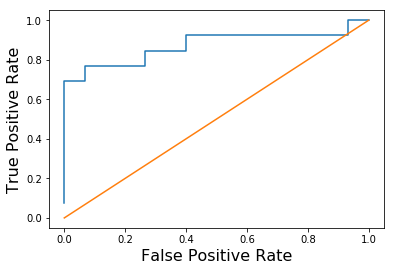

In [32]:
from sklearn.metrics import roc_curve

pred_proba = lr.predict_proba(X_test)

# turn multiclass problem into binary problem
pred_proba_1 = 1.0 - pred_proba[:, 0]
y_test_1 = [0 if y == 0 else 1 for y in y_test]

fpr, tpr, _ = roc_curve(y_test_1, pred_proba_1)

plt.plot(fpr, tpr)
plt.plot([0.0, 1.0], [0.0, 1.0])
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)